In [1]:

# Necessary imports
import os
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn import metrics
from sklearn.model_selection import train_test_split


In [2]:

# Load the dataset
dataframe = pd.read_csv('Petrol CSV w Date.csv')

# Convert 'date' column to datetime format
dataframe['date'] = pd.to_datetime(dataframe['date'])

# Preview the dataset
dataframe.head()


,date,PETROLEUM ENERGY PRODUCTS CONSUMPTION BY FUEL-Motor Spirit
0,1970-01-01 00:00:00.000001980,542254.0
1,1970-01-01 00:00:00.000001981,589017.0
2,1970-01-01 00:00:00.000001982,644907.0
3,1970-01-01 00:00:00.000001983,690214.0
4,1970-01-01 00:00:00.000001984,754725.0


In [3]:

# Create features function
def create_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    return df

# Add features to the original dataframe
dataframe = create_features(dataframe)

# Preview the dataframe with new features
dataframe.head()


,date,PETROLEUM ENERGY PRODUCTS CONSUMPTION BY FUEL-Motor Spirit,year,month,day,dayofweek,is_weekend
0,1970-01-01 00:00:00.000001980,542254.0,1970,1,1,3,0
1,1970-01-01 00:00:00.000001981,589017.0,1970,1,1,3,0
2,1970-01-01 00:00:00.000001982,644907.0,1970,1,1,3,0
3,1970-01-01 00:00:00.000001983,690214.0,1970,1,1,3,0
4,1970-01-01 00:00:00.000001984,754725.0,1970,1,1,3,0


In [4]:
# rename a cloumn in the dataframe

dataframe = dataframe.rename(columns={'PETROLEUM ENERGY PRODUCTS CONSUMPTION BY FUEL-Motor Spirit': 'consumption'})

In [5]:
# Splitting the data into features and target
X = dataframe.drop(['consumption', 'date'], axis=1)  # 'consumption' is the target column
y = dataframe['consumption']  # Define the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (35, 5)
y_train shape: (35,)
X_test shape: (9, 5)
y_test shape: (9,)


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import xgboost as xgb
import numpy as np

# Step 1: Define the parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

In [7]:
# Step 2: Initialize XGBRegressor for GridSearchCV
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Optimize for MSE
    cv=3,                              # 3-fold cross-validation
    verbose=1,
    n_jobs=-1                          # Use all available CPUs
)


In [8]:
# Step 3: Perform GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print("\nBest Parameters from GridSearchCV:")
print(best_params)

# Step 4: Convert datasets to DMatrix for xgb.train
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Step 5: Define parameters for xgb.train using best_params
params = {
    'objective': 'reg:squarederror',
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'colsample_bytree': best_params['colsample_bytree'],
    'eval_metric': 'rmse'  # Default evaluation metric
}



Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best Parameters from GridSearchCV:
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [9]:
# Step 6: Train the model using xgb.train
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_params['n_estimators'],  # Use the best number of estimators
    evals=[(dtrain, "train"), (dtest, "test")],  # Train and validation sets
    early_stopping_rounds=10,                    # Stop if no improvement for 10 rounds
    verbose_eval=True                            # Show training progress
)

# Step 7: Predict on the test set
y_pred = xgb_model.predict(dtest)

# Step 8: Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Step 9: Print the evaluation metrics
print("\nEvaluation Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")


[0]	train-rmse:2489935.05911	test-rmse:2759730.83804
[1]	train-rmse:2489935.05911	test-rmse:2759730.83804
[2]	train-rmse:2489935.05911	test-rmse:2759730.83804
[3]	train-rmse:2489935.05911	test-rmse:2759730.83804
[4]	train-rmse:2489935.05911	test-rmse:2759730.83804
[5]	train-rmse:2489935.05911	test-rmse:2759730.83804
[6]	train-rmse:2489935.05911	test-rmse:2759730.83804
[7]	train-rmse:2489935.05911	test-rmse:2759730.83804
[8]	train-rmse:2489935.05911	test-rmse:2759730.83804
[9]	train-rmse:2489935.05911	test-rmse:2759730.83804
[10]	train-rmse:2489935.05911	test-rmse:2759730.83804

Evaluation Metrics:
R² Score: -0.1231
Mean Squared Error (MSE): 7616113528898.0088
Root Mean Squared Error (RMSE): 2759730.6986
Mean Absolute Percentage Error (MAPE): 0.9637


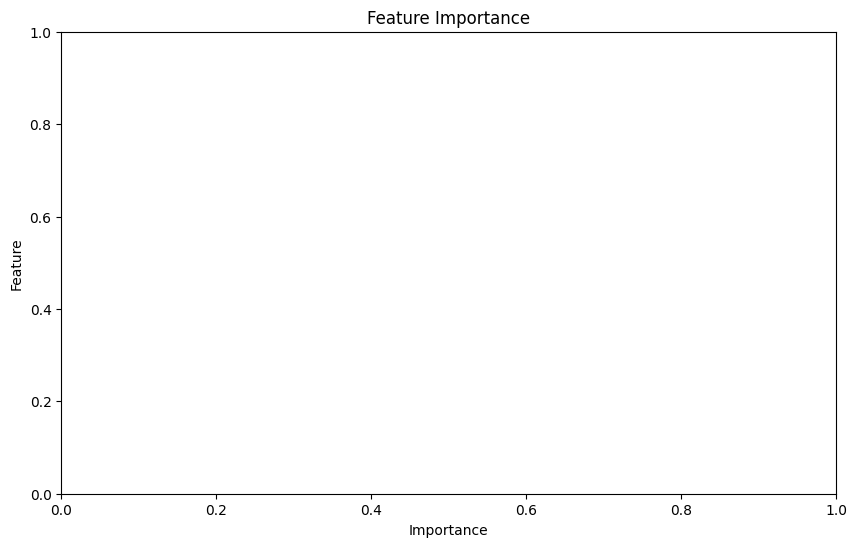

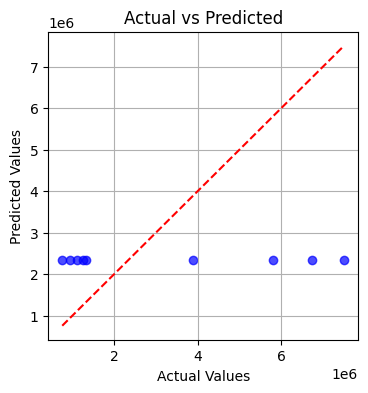

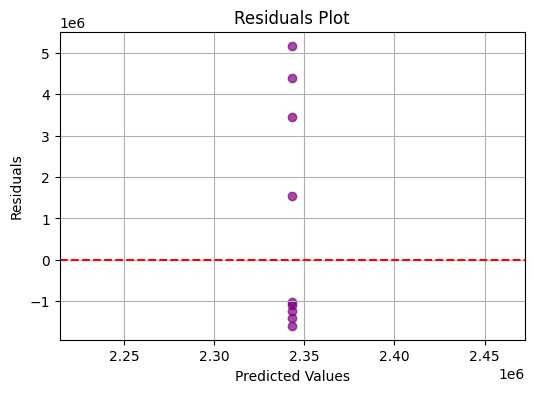

c:\Users\MoaviaHassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\MoaviaHassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


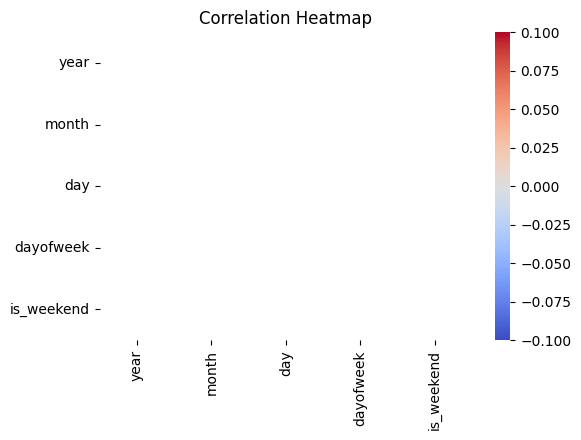


Evaluation Metrics:
R² Score: -0.1231
Mean Squared Error (MSE): 7616113528898.0088
Root Mean Squared Error (RMSE): 2759730.6986
Mean Absolute Percentage Error (MAPE): 0.9637


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Step 1: Feature Importance Plot
def plot_feature_importance(model, feature_names):
    feature_importance = model.get_score(importance_type="weight")
    keys = list(feature_importance.keys())
    values = list(feature_importance.values())
    
    # Create DataFrame for sorting and plotting
    feature_importance_df = pd.DataFrame({'Feature': keys, 'Importance': values})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

plot_feature_importance(xgb_model, X_train.columns)

# Step 2: Actual vs Predicted Plot
def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(4, 4))
    plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()

plot_actual_vs_predicted(y_test, y_pred)

# Step 3: Residuals Plot
def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.7, color='purple')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residuals Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

plot_residuals(y_test, y_pred)

# Step 4: Precision, Recall, F1 Score (Classification Only)
# For regression, skip this part. If you're working on classification, uncomment below:
# precision = precision_score(y_test_class, y_pred_class, average='binary')  # Replace with appropriate averaging method
# recall = recall_score(y_test_class, y_pred_class, average='binary')
# f1 = f1_score(y_test_class, y_pred_class, average='binary')
# print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Step 5: Correlation Heatmap
def plot_correlation_heatmap(data):
    plt.figure(figsize=(6, 4))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(pd.DataFrame(X_train, columns=X_train.columns))

# Step 6: Evaluation Metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
